In [2]:
#  CSC6740 Term Project
#  Georgia State University - Fall 2020
#  William Keith Dobson
#  Version 1.0
#  News story Sentiment analyzer 
#  Loads scraped RSS news feed pickle files then downloads news article text for stories that include the user 
#  specified search term(s) in its title.  It then cleans each story text and computes sentiment polarity and 
#  subjectivity of the reporting which is stored using the same filename with a "sent-" prefix added

# Library dependencies
import requests
#from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from textblob import TextBlob
from wordcloud import WordCloud
from newspaper import Article    # this is a better tool for capturing article text bodies than beautiful soup
import matplotlib.pyplot as plt
from collections import Counter 
import pickle
import datetime 
import re
import string
import numpy as np

# sets the minimum number of characters in news stories mined
newsMinChar = 600

rssfilelist = [ \
            "rss/rss_all_2020-11-06.p", \
            "rss/rss_all_2020-11-05.p", \
            "rss/rss_all_2020-11-04.p", \
            "rss/rss_all_2020-11-03.p", \
            "rss/rss_all_2020-11-02.p", \
            "rss/rss_all_2020-11-01.p", \
            "rss/rss_all_2020-10-31.p", \
            "rss/rss_all_2020-10-30.p", \
            "rss/rss_all_2020-10-29.p", \
            "rss/rss_all_2020-10-28.p", \
            "rss/rss_all_2020-10-27.p", \
            "rss/rss_all_2020-10-26.p", \
            "rss/rss_all_2020-10-25.p", \
            "rss/rss_all_2020-10-24.p" \
           ]
# List of all news sources mined        
#keylist = ['bbc', 'cnbc', 'cnn', 'foxnews', 'nbcnews', 'npr', 'nyt', 'washpost', 'washtimes', 'wsj' ]
keylist = ['bbc', 'cnbc', 'cnn', 'foxnews', 'npr', 'nyt', 'washpost', 'washtimes', 'wsj' ]
keyexclusionlist = ['nbcnews', 'telegraph', 'cbsnews'] # exactly same as wsj

# list of dates for web scraping 
datelist = ['2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31',\
            '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06' ]

# Generate global equally spaced news colors in spectral palette for plotting 
jet = plt.cm.jet
colors = jet(np.linspace(0.05, 0.95, len(keylist)))
newscolor = {}
for k, color in zip(keylist, colors):
    newscolor[k] = color    
# News markers global
newsmarker = {'bbc':'v', 'cbsnews': 'o', 'cnbc':'p', 'cnn':'s', 'foxnews':'v', 'nbcnews':'o', 'nyt':'p', 'npr':'s', 'washpost':'v', 'washtimes': 'o',  'wsj':'s' }

# Function to display news items library
#  uses flag parameter to limit output 
#  0 = just news sources
#  1 = news source + title
#  2 = news source + title + description
#  3 = news source + title + description + text
def displayNews(news_items, flag):
    for item in news_items:
        print("----"+item['key']+"----")
        if(flag >= 1):
            print("[TITLE] "+item["key"]+" - "+item["title"])
        if(flag >= 2):
            print("[DESC] "+item["description"]) 
        if(flag >= 3 and len(item["text"]) > 100):
            print("[TEXT] "+item["text"])
    return

# Function to search and display all news items from a specificed news source k
def searchNews(news_items, k):
    cnt = 0
    for item in news_items:
        if item['key'] == k :
            cnt += 1
            print("----"+item['key']+"----")
            print("[TITLE] "+item["key"]+" - "+item["title"]+' - '+item['date'])
            print("[DESC] "+item["description"]) 
            print("[TEXT] "+item["text"])
    print('=====  Total Stories Found: '+str(cnt))
    return

# Function to search and filter news items that include the sterm and excludes nterm
# fmode = 1 search title and description,  fmode = 2 search only titles, fmode = 3 search titles and desc exclude term not in title, fmode = 0 bypass
def filterNews(news_items, sterm, nterm, fmode):
    filtered_items = []
    cnt = 0
    for item in news_items:
        if fmode == 1:   # totally exclusive no nterm in title or desc
            if (sterm in item['title'].lower() or sterm in item['description'].lower()) and nterm not in item['title'].lower() and nterm not in item['description'].lower():
                cnt += 1
                filtered_items.append(item)
        elif fmode == 2:  # title only exclusion of nterm
            if sterm in item['title'].lower()  and nterm not in item['title'].lower():  # just title
                cnt += 1  
                filtered_items.append(item)
        elif fmode == 3:    # title and desc for sterm but not in title for nterm
            if (sterm in item['title'].lower() or sterm in item['description'].lower()) and nterm not in item['title'].lower() :
                cnt += 1
                filtered_items.append(item)
        else:
            filtered_items.append(item)   # else bypass
            cnt += 1
            
    print('Filter items found = '+str(cnt)+' out of total = '+str(len(news_items)))
    return filtered_items


# Function to convert text string to lower case then remove punctuation and numbers
def cleanPunctNum(text):
    #Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[^A-Za-z ]+', ' ', text)   # remove any other special characters
    return text


# Function to pickle news_items list    
def saveNewsItems(news_items, fname):    
    # save the news items
    pickle.dump(news_items, open(fname, "wb"))
    print("==== File:   " + fname + " ... Pickled with "+str(len(news_items))+" stories written.")
    return

# Function that searches news_items and returns item with min or max of polarity or sujectivity
# fmode: 0 = max polarity, 1 = max subjectivity, 2 = min polarity, 3 = min subjectivity, 4 = max pol and subj, 5 = min pol and subj
def findItem(news_items, dlist, klist, fmode):
    fitem = news_items[0]
    for item in news_items:
        if item['date'] in dlist and item['key'] in klist:
            if fmode == 0 and item['polarity'] >= fitem['polarity']:
                fitem = item
            elif fmode == 1 and item['subjectivity'] >= fitem['subjectivity']:
                fitem = item
            elif fmode == 2 and item['polarity'] <= fitem['polarity']:
                fitem = item
            elif fmode == 3 and item['subjectivity'] <= fitem['subjectivity']:
                fitem = item
            elif fmode == 4 and item['polarity'] >= fitem['polarity'] and item['subjectivity'] >= fitem['subjectivity']:
                fitem = item
            elif fmode == 5 and item['polarity'] <= fitem['polarity'] and item['subjectivity'] <= fitem['subjectivity']:
                fitem = item
   
    return fitem

# Function to scrape the story text from a news webpage using newspaper library 
def scrapeText(link):
    try: 
        test_article = Article(link, language="en", timeout = 10)
        test_article.download()
        test_article.parse()
    except:
        pass
    
    text = test_article.text
    return text

# Data structure for analytic data from mining
class n_analytics :
    def __init__(self):
        self.pol = []
        self.subj = []
        self.cnt = 0
        self.polmean = 0
        self.subjmean = 0
        self.polstd = 0
        self.subjstd = 0
        self.polvar = 0
        self.subjvar = 0
        

# Function for simple linear regression
def linReg(x, y):
    import numpy as np
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()
    x1 = np.array(x)
    y1 = np.array(y)
    x1 = x1.reshape(-1,1)
    
    #print(x1)
    #print(y1)
    if np.isnan(x1).any() or np.isnan(y1).any() :
        print('Error NaN detected! ')
        print(x1)
        print(y1)
    else:
        linreg.fit(x1,y1)
    
    yp = linreg.predict(x1)
    return yp

# Function to interpolate missing y data points using mean of non-zero points then linear regression of the updated set
def interp(x, y):
    yterms = []
    for i in range(len(y)):   # find mean of non zero y terms first
        if y[i] != 0 :
            yterms.append(y[i])
    yavg = np.mean(np.array(yterms))    
    
    yt = []
    for i in range(len(y)):  # fill in zero terms with avg
        if y[i] == 0:
            yt.append(yavg)
        else:
            yt.append(y[i])

    yr = linReg(x, yt)   # find regression values of y
    
    yi = []
    for i in range(len(y)):  # fill in zero terms with regress values
        if y[i] == 0:
            yi.append(yr[i])
        else:
            yi.append(y[i])
    return yi

# Function returns a dictionary of analytic values based on news source (key)
def avgSent(news_items, sdate, klist):
    ndic = {}
    for k in klist:     # build dictionary to hold class objects
        ndic[k]=n_analytics()

    for item in news_items:
        if (item['date'] == sdate or sdate == '*') and float(item['polarity']) != 0 and float(item['subjectivity']) != 0 and item['key'] in klist:
            ndic[item['key']].cnt += 1
            ndic[item['key']].pol.append( float(item['polarity']) ) # was +=
            ndic[item['key']].subj.append( float(item['subjectivity']) )
            #print(item['date']+" "+item['key']+" "+str(ndic[item['key']].pol) + " " +date+" "+ str(ndic[item['key']].subj) + " " + str(ndic[item['key']].cnt ))
            
    # compute basic statistics with numpy and save in class object    
    for k in klist:    
        if ndic[k].cnt>0 :    # Avoid div by 0 if no stories found
            P = np.array(ndic[k].pol)
            S = np.array(ndic[k].subj)
            ndic[k].polmean = np.mean(P)     # find mean
            ndic[k].subjmean = np.mean(S)
            ndic[k].polstd = np.std(P)       # find standard deviation
            ndic[k].subjstd = np.std(S)
            ndic[k].polvar = np.var(P)       # find variance
            ndic[k].subjvar = np.var(S)
            #print(k +" "+str(ndic[k].polmean)+" "+ str(ndic[k].subjmean) +" "+ str(ndic[k].polstd) +" "+ str(ndic[k].subjstd) +" "+ str(ndic[k].cnt) )     
    return ndic

# Function to compute avg sentiment over multiple days in datelist and return a dictionary of data organized by date
def avgSentMultiDay(news_items, dlist, klist):
    sentlist = {}
    for d in dlist:
        sentlist[d] = avgSent(news_items, d, klist)
        #print(d+" items averaged")           
    return sentlist

############################### Plotting #######################################


# Function to daily average sentiment by news source
def plotDayScatAvg(news_items, sdate, klist):
    import matplotlib.pyplot as plt

    newsavgs = avgSent(news_items, sdate, klist)
    sterm = news_items[0]['sterm']
    
    plt.rcParams['figure.figsize'] = [14, 10]
    
    leglist = []  
    for k in klist:  
        try:
            x = newsavgs[k].polmean
            y = newsavgs[k].subjmean
            #print(d+" "+k+" "+str(x)+" "+str(y))
            if x != 0 or y != 0:  # only plot when valid sentiment values exist      
                if k not in leglist:
                    leglist.append(k)
                plt.scatter(x, y, color=newscolor[k], label = k, marker=newsmarker[k], s = newsavgs[k].cnt*40)
                if k == 'wsj':
                    plt.text(x+.001, y-.001, k+':'+str(newsavgs[k].cnt), fontsize=14)
                else:
                    plt.text(x+.001, y+.001, k+':'+str(newsavgs[k].cnt), fontsize=14)
        except:
            print('### Missing key: '+k)
                
    #print(newsmarker)
    plt.legend(leglist)
    plt.title('Mean Sentiment: '+sterm+" on Date: "+sdate, fontsize=20)
    plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
    plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

    plt.autoscale()
    plt.show()    
    return

def plotDayScatInd(news_items, sdate, klist):
    import matplotlib.pyplot as plt

    sterm = news_items[0]['sterm']
    
    plt.rcParams['figure.figsize'] = [14, 10]

  
    for item in news_items:
        x = float(item['polarity'])
        y = float(item['subjectivity'])
        k = str(item['key'])
        if (x != 0 or y != 0) and item['date'] == sdate and k not in keyexclusionlist:  # only plot when valid sentiment values exist      
            plt.scatter(x, y, color = newscolor[k], label = k, marker=newsmarker[k], s = 100)           
            if item['key'] == 'wsj':
                plt.text(x+.001, y-.001, item['key'], fontsize=14)
            else:
                plt.text(x+.001, y+.001, item['key'], fontsize=14)
    
    #plt.legend()  # legend feature does not work with random order scatter plots
    plt.title('Individual Story Sentiment: '+sterm+" on Date: "+sdate, fontsize=20)
    plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
    plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

    plt.autoscale()
    plt.show()    
    return

def plotMultiDayScatAvg(news_items, dlist, klist):
    import matplotlib.pyplot as plt

    newsavgs = avgSentMultiDay(news_items, dlist, klist)
    sterm = news_items[0]['sterm']
    
    plt.rcParams['figure.figsize'] = [14, 10]
    fig = plt.figure()
    ax = fig.add_subplot()

    for d in dlist: 
        for k in klist:             
            x = newsavgs[d][k].polmean
            y = newsavgs[d][k].subjmean
            if x != 0 or y != 0:  # only plot when valid sentiment values exist      
                ax.scatter(x, y, color=newscolor[k], label = k, marker = newsmarker[k], s = newsavgs[d][k].cnt*40)
    
    handles, labels = ax.get_legend_handles_labels()  # code to fix multiple legend entries
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

    plt.title('Daily Mean Sentiment: '+sterm+" for Period "+dlist[0] +" to "+dlist[-1], fontsize=20)
    plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
    plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

    plt.autoscale()
    plt.show()    
    return

# Function to find the total average sentiment by news source for the period specified in datelist
def avgSentMultiDayTotal(sentlist, dlist, klist):
    x = np.arange(0, len(dlist))
    
    savg = {}
    for k in klist:     # build dictionary to hold class objects
        savg[k]=n_analytics()
    
    for d in dlist:  # append sentiments
        for k in klist:
            savg[k].pol.append(sentlist[d][k].polmean)
            savg[k].subj.append(sentlist[d][k].subjmean)
            savg[k].cnt += sentlist[d][k].cnt
    for k in klist:                   # calc overall means and stats
        if all([ v == 0 for v in savg[k].pol]) :
            print('No data detected! '+k)
        else:
            P = interp(x, np.array(savg[k].pol))
            S = interp(x, np.array(savg[k].subj))
            savg[k].polmean = np.mean(P)     # find mean
            savg[k].subjmean = np.mean(S)
            savg[k].polstd = np.std(P)       # find standard deviation
            savg[k].subjstd = np.std(S)
            savg[k].polvar = np.var(P)       # find variance
            savg[k].subjvar = np.var(S)
    return savg

# Function to do a scatterplot of total average sentiment by news source
def plotTotalScatAvg(news_avgs, dlist, klist):
    import matplotlib.pyplot as plt
    tavg = avgSentMultiDayTotal(news_avgs, dlist, klist)
    sterm = news_items[0]['sterm']

    plt.rcParams['figure.figsize'] = [14, 10]

    for k in klist:  
        x = tavg[k].polmean
        y = tavg[k].subjmean
        if x != 0 or y != 0:  # only plot when valid sentiment values exist      
            plt.scatter(x, y, color=newscolor[k], s = tavg[k].cnt*40,label = k)
            if k == 'wsj' or k == 'cnbc':
                plt.text(x+.001, y-.001, k+':'+str(tavg[k].cnt), fontsize=14)
            else:
                plt.text(x+.001, y+.001, k+':'+str(tavg[k].cnt), fontsize=14)
        
    #plt.legend(klist)
    plt.title('Total Mean Sentiment: '+sterm+" for Period "+dlist[0] +" to "+dlist[-1], fontsize=20)
    plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
    plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

    plt.autoscale()
    plt.show()    
    return

# Function to do a scatterplot of total average sentiment by news source
def plotTotalScatAvgClusters(news_avgs, dlist, klist, eps):
    import matplotlib.pyplot as plt
    tavg = avgSentMultiDayTotal(news_avgs, dlist, klist)
    sterm = news_items[0]['sterm']

    plt.rcParams['figure.figsize'] = [14, 10]
    tdata = []
    for k in klist:  
        x = tavg[k].polmean
        y = tavg[k].subjmean
        tdata.append([x,y])
        
    X = np.array(tdata)
    db = DBSCAN(eps=eps, min_samples=2).fit(X)
    labels = db.labels_
    colors1 = {} 
    colors1[0] = 'r'
    colors1[1] = 'c'
    colors1[2] = 'm'
    colors1[3] = 'g'
    colors1[4] = 'b'
    colors1[5] = 'k'
    colors1[-1] = 'y'
    cvec = [colors1[label] for label in labels] 
    colors = ['r', 'c', 'm', 'g', 'b', 'k', 'y' ] 
    i = 0
    for k in klist:
        x = tdata[i][0]
        y = tdata[i][1]
        if x != 0 or y != 0:  # only plot when valid sentiment values exist 
            plt.scatter(x, y, color=cvec[i], s = 250,label = k)
            if k == 'wsj' or k == 'cnbc':
                plt.text(x+.002, y-.001, k+':'+str(tavg[k].cnt), fontsize=14)
            else:
                plt.text(x+.002, y+.001, k+':'+str(tavg[k].cnt), fontsize=14)
        i += 1

    #plt.legend(klist)
    plt.title('Total Mean DBSCAN Clusters eps='+str(eps)+': '+sterm+" for "+dlist[0] +" to "+dlist[-1], fontsize=20)
    plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
    plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

    plt.autoscale()
    plt.show()    
    return 

#######################################################################################################
# Function to plot sentiment over multiple days with or without regression
# pmode:  0 = raw polarity, 1 = raw subjectivity, 2 = pol regression, 3 = subj regression, 4 = pol reg+scat, subj reg+scat
def plotMultiDay(news_items, dlist, klist, pmode):
    import matplotlib.pyplot as plt    
    test2 = avgSentMultiDay(news_items, dlist, klist)

    plt.rcParams['figure.figsize'] = [14, 10]

    datelabels = []
    for d in dlist:            # abbreviated dates for graphs
        datelabels.append(d[-5:]) 

    sterm = news_items[0]['sterm']  # grab search term for graphs
    
    x = np.arange(0, len(dlist))

    fig = plt.figure()
    ax = fig.add_subplot()
    
    for k in klist:  
        y1 = []
        lnzpol = 0
        lnzsub = 0
        if k not in keyexclusionlist:  #hack to cover incomplete sources
            for d in dlist:
                if test2[d][k].polmean != 0:      # kludge to handle missing stories
                    lnzpol = test2[d][k].polmean
                if test2[d][k].subjmean != 0:
                    lnzsub = test2[d][k].subjmean
                    
                if pmode%2 == 0:
                    y1.append(test2[d][k].polmean)
                else:
                    y1.append(test2[d][k].subjmean)
            
            if np.sum(y1) == 0:
                print("All zero data! "+k+" "+d)
            else:
                y1 = interp(x, y1)    # fills in any zero y terms in raw data            
                y2 = linReg(x, y1)    # find regression line
            
                if pmode < 2:          # For pmode = 0 or 1 plot data
                    yp = y1           
                else:                  # otherwise plot regression
                    yp = y2            
                
                ax.plot(x,yp,color=newscolor[k],marker=newsmarker[k],ls='--',label=k, fillstyle='none')
                
                if pmode > 3:
                    ax.scatter(x,y1,color=newscolor[k],marker=newsmarker[k],ls='--')
                
    if pmode == 0:
        plt.title('Mean Polarity Over Time: '+sterm, fontsize=20)
        plt.ylabel('<-- Negative -------- Positive -->', fontsize=15)
    elif pmode == 1:
        plt.title('Mean Subjectivity Over Time: '+sterm, fontsize=20)
        plt.ylabel('<-- Facts -------- Opinion -->', fontsize=15)
    elif pmode == 2:
        plt.title('Mean Polarity Regression Over Time: '+sterm, fontsize=20)
        plt.ylabel('<-- Negative -------- Positive -->', fontsize=15)
    elif pmode == 3:
        plt.title('Mean Subjectivity Regression Over Time: '+sterm, fontsize=20)
        plt.ylabel('<-- Facts -------- Opinion -->', fontsize=15)
    elif pmode == 4:
        plt.title('Mean Polarity Regression +Scat Over Time: '+sterm, fontsize=20)
        plt.ylabel('<-- Facts -------- Opinion -->', fontsize=15)
    else:
        plt.title('Mean Subjectivity Regression +Scat Over Time: '+sterm, fontsize=20)
        plt.ylabel('<-- Facts -------- Opinion -->', fontsize=15)
        
    plt.xlabel('--- Days -->', fontsize=15)
    plt.legend(loc=2)
    plt.autoscale()
    plt.xticks(x, datelabels)    
    return


#######################################################################################################
# Function to plot sentiment over multiple days with regression as a dual window plot
# pmode:  0 = raw polarity, 1 = raw subjectivity, 2 = pol regression, 3 = subj regression, 4 = pol reg+scat, subj reg+scat
def plotDualMultiDay(news_items, dlist, klist, pmode):
    import matplotlib.pyplot as plt    
    test2 = avgSentMultiDay(news_items, dlist, klist)

    datelabels = []
    for d in dlist:            # abbreviated dates for graphs
        datelabels.append(d[-5:]) 

    sterm = news_items[0]['sterm']  # grab search term for graphs
    
    x = np.arange(0, len(dlist))

    plt.rcParams['figure.figsize'] = [14, 12]

    fig, (ax1, ax2) = plt.subplots(2)
    plt.setp(ax1, xticks=x, xticklabels=datelabels)
    plt.setp(ax2, xticks=x, xticklabels=datelabels)

    if pmode == 0:
        fig.suptitle('Mean Polarity Over Time: '+sterm, fontsize=20)
        plt.setp(ax1, ylabel = '<-- Negative ---- Positive -->', xlabel = '--- Days -->' )
        plt.setp(ax2, ylabel = '<-- Negative ---- Positive -->', xlabel = '--- Days -->' )
    elif pmode == 1:
        fig.suptitle('Mean Subjectivity Over Time: '+sterm, fontsize=20)
        plt.setp(ax1, ylabel = '<-- Facts ---- Opinion -->', xlabel = '--- Days -->' )
        plt.setp(ax2, ylabel = '<-- Facts ---- Opinion -->', xlabel = '--- Days -->' )

    ax1.set_title('Unfiltered Data')
    ax2.set_title('Regression Lines')

    for k in klist:  
        y1 = []
        if k not in keyexclusionlist:  #hack to cover incomplete sources
            for d in dlist:                    
                if pmode%2 == 0:
                    y1.append(test2[d][k].polmean)                    
                else:
                    y1.append(test2[d][k].subjmean)
            
            if np.sum(y1) == 0:
                print("All zero data! "+k+" "+d)
            else:
                y1 = interp(x, y1)    # fills in any zero y terms in raw data            
                y2 = linReg(x, y1)    # find regression line
            
                ax1.plot(x,y1,color=newscolor[k],marker=newsmarker[k],ls='--',label=k, fillstyle='none')
                ax2.plot(x,y2,color=newscolor[k],marker=newsmarker[k],ls='--',label=k, fillstyle='none')
                
                if len(klist)<4:
                    ax2.scatter(x,y1,color=newscolor[k],marker=newsmarker[k],ls='--')
                
    plt.setp(ax1, xlabel = '--- Days --->')
    plt.setp(ax2, xlabel = '--- Days --->')
    plt.setp(ax1, xticks=x, xticklabels=datelabels)
    plt.setp(ax2, xticks=x, xticklabels=datelabels)
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    #plt.autoscale()
    return


# Function to open two news avg files and plot the difference in sentiments by news source for dates given
def plotSentDiffBar(fname1, fname2, dlist, klist, pmode):
    newsavgs1 = {}
    newsavgs2 = {}
    filehandler = open(fname1, 'rb') 
    newsavgs1 = pickle.load(filehandler)
    filehandler = open(fname2, 'rb') 
    newsavgs2 = pickle.load(filehandler)
    plt.rcParams['figure.figsize'] = [14, 10]

    fn1 = fname1.split('_')
    fn2 = fname2.split('_')
    
    datelabels = []
    for d in dlist:            # abbreviated dates for graphs
        datelabels.append(d[-5:]) 
            
    x = np.arange(0, len(dlist))
    
    fig = plt.figure()
    ax = fig.add_subplot()
    width = 1/(len(klist)+1)
    w=0
    yt=[]  # totals for yp
    
    for k in klist: 
        yp = []
        for d in dlist:
            if pmode == 0:
                yp.append(newsavgs1[d][k].polmean - newsavgs2[d][k].polmean)
                stype = 'Polarity'
                yterm = '[favors]'
                ax.set_ylim(-0.25,0.25)
                ym = -0.249  #location for mean text
            else:
                yp.append(newsavgs1[d][k].subjmean - newsavgs2[d][k].subjmean)
                stype = 'Subjectivity'
                yterm = '[more subjective]'
                ax.set_ylim(-0.5,0.5)
                ym = -0.499 #location for mean text
    
        ax.bar(x+w,yp,width, color=newscolor[k], label = k)     
        w += width 
        yt.extend(yp)
    
    plt.title('Mean '+stype+' Difference: '+fn1[1]+"-"+fn2[1]+" "+dlist[0] +" to "+dlist[-1], fontsize=20)
    plt.xlabel('--- Days -->', fontsize=15)
    plt.ylabel('<-- '+fn2[1]+' ------ '+yterm+' ----- '+fn1[1]+' -->', fontsize=15)
    
    ax.xaxis.grid(True)
    ax.axhline(0.0)   
    ax.axhline(np.mean(yt), color = 'c', linestyle=':')
    plt.text(0.001, ym, 'mean diff = '+str(np.mean(yt)), fontsize=14)
    plt.legend(loc=2)
    plt.xticks(x, datelabels)
    #plt.autoscale()
    plt.show()    
    return

# Function that plots the daily frequencies of news stories over time 
def plotNewsFreq(news_items, dlist):   
    sterm = news_items[0]['sterm']
    
    datelabels = []
    for d in dlist:            # abbreviated dates for graphs
        datelabels.append(d[-5:]) 
    
    freqs = {}
    for d in dlist:
        freqs[d] = 0
    
    for item in news_items:  # tally the frequencies
        freqs[item['date']] += 1
    
    yp = []
    for d in dlist:
        yp.append(freqs[d])
        
    x = np.arange(0, len(dlist))
    plt.rcParams['figure.figsize'] = [14, 10]
    fig = plt.figure()
    ax = fig.add_subplot()
    width = 0.2
    
    ax.bar(x,yp,width, color=newscolor['foxnews'], label = 'freq') 

    plt.title('News Story Frequencies: '+sterm+' '+dlist[0]+" to "+dlist[-1], fontsize=20)
    plt.xlabel('--- Days -->', fontsize=15)
    plt.ylabel('<-- Frequency -->', fontsize=15)
    
    ax.xaxis.grid(True)
    yz = 0.0
    ax.axhline(yz)
    plt.legend(loc=2)
    plt.xticks(x, datelabels)
    plt.autoscale()
    plt.show()       
    return

# Function to open two news avg files and plot the difference in sentiments by news source for dates given
def plotSentDiffScat(fname1, fname2, dlist, klist):
    newsavgs1 = {}
    newsavgs2 = {}
    filehandler = open(fname1, 'rb') 
    newsavgs1 = pickle.load(filehandler)
    filehandler = open(fname2, 'rb') 
    newsavgs2 = pickle.load(filehandler)
    plt.rcParams['figure.figsize'] = [14, 10]

    fn1 = fname1.split('_')
    fn2 = fname2.split('_')
    
    datelabels = []
    for d in dlist:            # abbreviated dates for graphs
        datelabels.append(d[-5:]) 
            
    fig, ax = plt.subplots()
    miny = 2
    minx = 2
    x1m = []
    y1m = []
    x2m = []
    y2m = []
    for k in klist: 
        x1 = [] 
        x2 = [] 
        y1 = []
        y2 = []
        for d in dlist:           
            if newsavgs1[d][k].polmean != 0.0 and newsavgs1[d][k].subjmean != 0.0 and k not in keyexclusionlist:
                x1.append(newsavgs1[d][k].polmean)
                y1.append(newsavgs1[d][k].subjmean)
            if newsavgs2[d][k].polmean != 0.0 and newsavgs2[d][k].subjmean != 0.0 and k not in keyexclusionlist:
                x2.append(newsavgs2[d][k].polmean)
                y2.append(newsavgs2[d][k].subjmean)
            
        
        if len(x1) > 0 and len(y1) > 0:
            if np.min(x1) < minx:   # log min x for text 
                minx = np.min(x1)
            if np.min(y1) < miny:   # log min y for text 
                miny = np.min(y1)
            x1m.append(np.mean(x1))
            y1m.append(np.mean(y1))

            scatter = ax.scatter(x1, y1, c='b', s=80)      

        if len(x2) > 0 and len(y2) > 0:
            if np.min(x2) < minx:
                minx = np.min(x2)
            if np.min(y2) < miny:
                miny = np.min(y2)            
            x2m.append(np.mean(x2))
            y2m.append(np.mean(y2))
            scatter = ax.scatter(x2, y2, c='r', s=80)
        
    scatter = ax.scatter([np.mean(x1m)], [np.mean(y1m)], c='b', s=250, label = fn1[1], marker = 's')
    plt.text(np.mean(x1m)+.001, np.mean(y1m)+.001, 'mean:'+fn1[1], fontsize=14)
    scatter = ax.scatter([np.mean(x2m)], [np.mean(y2m)], c='r', s=250, label = fn2[1], marker = 's')
    plt.text(np.mean(x2m)+.001, np.mean(y2m)+.001, 'mean:'+fn2[1], fontsize=14)
    
    plt.text(minx, miny, 'Diff Means: '+fn1[1]+'-'+fn2[1]+' dx = '+ str(np.mean(x1m)-np.mean(x2m))\
             +' dy = '+str(np.mean(y1m)-np.mean(y2m)), fontsize = 14)
    
    ax.legend(loc='upper left')
    plt.title('Mean Sentiments Over Time: '+fn1[1]+", "+fn2[1]+" "+dlist[0] +" to "+dlist[-1], fontsize=20)
    plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
    plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)  
    #plt.autoscale()
    plt.show()  
    return

def plotWordCloud(newstext, key, title, stop_words):
    #stop_words = text.ENGLISH_STOP_WORDS
    wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

    wc.generate(newstext)

    if len(title) > 60:    # wrap text once for long story titles
        x = title[50:60].find(' ')
        t1 = title[:x+50]
        t2 = title[x+51:]
        t = t1+'\n'+t2
    else:
        t = title
    plt.rcParams['figure.figsize'] = [16, 6]
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(key+' '+t, fontsize = 25)    
    plt.show()  
    return

# Function that plots the daily frequencies of news stories over time 
# pmode: 0 = pol var, 1 = subj var, 2 = pol std, 3 = subj std
def plotNewsStats(fname1, fname2, dlist, klist, pmode):   
    newsavgs1 = {}
    newsavgs2 = {}
    filehandler = open(fname1, 'rb') 
    newsavgs1 = pickle.load(filehandler)
    filehandler = open(fname2, 'rb') 
    newsavgs2 = pickle.load(filehandler)
    plt.rcParams['figure.figsize'] = [14, 10]

    fn1 = fname1.split('_')
    fn2 = fname2.split('_')
    
    datelabels = []
    for d in dlist:            # abbreviated dates for graphs
        datelabels.append(d[-5:]) 
            
    x = np.arange(0, len(dlist))
    
    fig = plt.figure()
    ax = fig.add_subplot()
    width = 1/(len(klist)+1)
    w=0
    yt=[]  # totals for yp
    miny =0
    
    for k in klist: 
        yp = []
        for d in dlist:
            if pmode == 0:
                yp.append(newsavgs1[d][k].polvar - newsavgs2[d][k].polvar)
                stype = 'Pol Var'
                yterm = '[variance]'
                #ax.set_ylim(-0.25,0.25)
                ym = -0.0065  #location for mean text
            elif pmode == 1:
                yp.append(newsavgs1[d][k].subjvar - newsavgs2[d][k].subjvar)
                stype = 'Subj Var'
                yterm = '[variance]'
                #ax.set_ylim(-0.5,0.5)
                ym = -0.0125 #location for mean text
            elif pmode == 2:
                yp.append(newsavgs1[d][k].polstd - newsavgs2[d][k].polstd)
                stype = 'Pol Std'
                yterm = '[std dev]'
                #ax.set_ylim(-0.5,0.5)
                ym = -0.080 #location for mean text
            elif pmode == 3:
                yp.append(newsavgs1[d][k].subjstd - newsavgs2[d][k].subjstd)
                stype = 'Subj Std'
                yterm = '[std dev]'
                #ax.set_ylim(-0.5,0.5)
                ym = -0.100 #location for mean text
            if yp[-1] <= miny:
                miny = yp[-1]

    
        ax.bar(x+w,yp,width, color=newscolor[k], label = k)     
        w += width 
        yt.extend(yp)
    
    plt.title('Mean '+stype+' Difference: '+fn1[1]+"-"+fn2[1]+" "+dlist[0] +" to "+dlist[-1], fontsize=20)
    plt.xlabel('--- Days -->', fontsize=15)
    plt.ylabel('<-- '+fn2[1]+' ------ '+yterm+' ----- '+fn1[1]+' -->', fontsize=15)
    
    ax.xaxis.grid(True)
    ax.axhline(0.0)   
    ax.axhline(np.mean(yt), color = 'c', linestyle=':')
    plt.text(0.1, miny, 'mean diff = '+str(np.mean(yt)), fontsize=14)
    plt.legend(loc=2)
    plt.xticks(x, datelabels)
    plt.autoscale()
    plt.show()    
    return

# Function to find and return total average by news source from two news analytics class objects
# tmode = 0 polarity, tmode = 1 subjectivity
def totalMean(tavg1, tavg2, klist, tmode):
    tavg = []
    for k in klist:
        try:
            
            if tavg1[k].polmean != 0 and tavg2[k].polmean != 0 and tmode == 0:
                tavg.append([k, np.mean([tavg1[k].polmean, tavg1[k].polmean])])    
            elif tavg1[k].subjmean != 0 and tavg2[k].subjmean != 0 and tmode == 1:
                tavg.append([k, np.mean([tavg1[k].subjmean, tavg1[k].subjmean])])    
                #print(tavg[k])
        except:
            print(k+' Not Found!')
   
    #print(tavg)                         
        #else:
            #break
           
    return tavg    

# Function to do dual scatterplots of total average sentiment by news source
def plotTotalScatAvg2(fname1, fname2, dlist, klist):
    import matplotlib.pyplot as plt
    newsavgs1 = {}
    newsavgs2 = {}
    filehandler = open(fname1, 'rb') 
    newsavgs1 = pickle.load(filehandler)
    filehandler = open(fname2, 'rb') 
    newsavgs2 = pickle.load(filehandler)
    
    fn1 =fname1.split('_')
    fn2 =fname2.split('_')
    
    tavg1 = avgSentMultiDayTotal(newsavgs1, dlist, klist)
    tavg2 = avgSentMultiDayTotal(newsavgs2, dlist, klist)
    
    #sterm1 = news_items[0]['sterm']

    plt.rcParams['figure.figsize'] = [14, 10]
    fig, ax = plt.subplots()
    for k in klist:  
        x1 = tavg1[k].polmean
        y1 = tavg1[k].subjmean
        x2 = tavg2[k].polmean
        y2 = tavg2[k].subjmean
        if x1 != 0 or y1 != 0:  # only plot when valid sentiment values exist      
            p1 = ax.scatter(x1, y1, color=newscolor['cnn'], s = tavg1[k].cnt*20,label = fn1[1])
            if k == 'wsj' or k == 'cnbc':
                ax.text(x1+.001, y1-.001, k+':'+str(tavg1[k].cnt), fontsize=14)
            else:
                ax.text(x1+.001, y1+.001, k+':'+str(tavg1[k].cnt), fontsize=14)
        if x2 != 0 or y2 != 0:  # only plot when valid sentiment values exist      
            p2 = ax.scatter(x2, y2, color=newscolor['washtimes'], s = tavg2[k].cnt*20,label = fn2[1])
            if k == 'wsj' or k == 'cnbc':
                ax.text(x2+.001, y2-.001, k+':'+str(tavg2[k].cnt), fontsize=14)
            else:
                ax.text(x2+.001, y2+.001, k+':'+str(tavg2[k].cnt), fontsize=14)

    plt.legend((p1, p2),
           (fn1[1], fn2[1]),
           scatterpoints=1,
           loc='lower left',
           ncol=1,
           fontsize=12)    
    
    plt.title('Total Mean Sentiment: '+fn1[1]+' & '+fn2[1]+" for Period "+dlist[0] +" to "+dlist[-1], fontsize=20)
    plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
    plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

    #plt.autoscale()
    plt.show()   
       
    # Added total average subjectivity of both datasets combined
    return totalMean(tavg1, tavg2, klist, 1)



In [9]:

# Get user search terms list
inputstring = input("Enter RSS/news filenames to mine (* = use hardcoded RSS list): ")
fnames = inputstring.split()
if len(fnames) == 0:      # just in case nothing entered
    print('###(input) Error - filename len = 0')
    quit()
    
if fnames[0] != '*':
    filelist = fnames
else:
    filelist = rssfilelist

# Get user search terms list
inputstring = input("Enter title search terms separated by spaces (* for all): ")
searchtermlist = inputstring.split()
if len(inputstring) == 0:    # just in case nothing entered
    searchtermlist = ['*']   
    
# Common filenames:  news/news_biden_2020-10-24-to-2020-11-06.p  news/news_trump_2020-10-24-to-2020-11-06.p


Enter RSS/news filenames to mine (* = use hardcoded RSS list):  news/news_trump_2020-10-24-to-2020-11-06.p
Enter title search terms separated by spaces (* for all):  *


In [10]:
#  Main Program Body

print("Be patient scraping article bodies takes time...")
save_items = []  # list to collect all news stories with complete text for later use

# Load pickled files and mine data
for fname in filelist:
    news_items = {}
    filehandler = open(fname, 'rb') 
    news_items = pickle.load(filehandler)
    print("====== File: "+fname+" opened for mining ====== ")
    
    temp_items = []
    
    ftmp = fname.split('.p')
    filedate = ftmp[0][-10:]
    ftmp = fname.split('/')   # get rid of path in filename
    fname = ftmp[1]

    # Loop to build a cleaned news items list for sentiment mining that merges items from multiple days into one list
    # Clean all news items.  Note that only the attributes needed are put into the new data objects.
    cleaned_cnews_items = []

    for item in news_items:
        for sterm in searchtermlist:
            tmpstr = item['title'].lower()+' '+item['description'].lower()
            if filelist == rssfilelist or 'rss' in fname:
                item['text'] = ' none '
                item['date'] = filedate  
                item['sterm'] = sterm      # added for later merging of stories
                
            if sterm == "*" or tmpstr.find(sterm.lower()) > 0:
                try:
                    if len(item['text']) < 10:      # if article body text not already retrieved get it
                        item['text'] = scrapeText(item['link'])
                except:
                    item['text'] = scrapeText(item['link'])
                                      
                cleaned_item = {}
                cleaned_item['key'] = item['key']
                try:
                    cleaned_item['date'] = item['date']
                except:
                    item['date'] = filedate 
                    cleaned_item['date'] = item['date']
                cleaned_item['title'] = item['title']
                cleaned_item['link'] = item['link']
                if sterm != '*':
                    cleaned_item['sterm']= sterm
                else:
                    cleaned_item['sterm']= item['sterm']
                cleaned_item['description'] = item['description']
                cleaned_item['text'] = cleanPunctNum(item['text']).strip() 
                cleaned_item['polarity'] = item['polarity']
                cleaned_item['subjectivity'] = item['subjectivity']
                
                if len(item['text']) >= newsMinChar and item['key'] != 'telegraph':     # only save stories with "enough" accessible text for mining
                    temp_items.append(item)                   # save copy of the raw uncleaned items that match search criterion
                    cleaned_cnews_items.append(cleaned_item)  # save cleaned text for sentiment mining
                    #print("item: "+item['key']+" added len = "+str(len(item['text']))+" "+item['date'])
                break
        
    # Put cleaned data into a pandas dataframe which works better with sklearn and TextBlob tools.
    pd.set_option('max_colwidth',150)

    cnews_df = pd.DataFrame.from_dict(cleaned_cnews_items) # build cleaned news data frame
    cnews_df = cnews_df.sort_index()
    # Create document-term matrix using CountVectorizer that excludes common English stop words
    cv = CountVectorizer(stop_words='english')
    cnews_cv = cv.fit_transform(cnews_df.text)
    cnews_dtm = pd.DataFrame(cnews_cv.toarray(), columns=cv.get_feature_names())
    cnews_dtm.index = cnews_df.index
    
    #####  Repeat dtm generation removing the most frequent words (optional set ntopwords=0 to bypass) ######    
    ntopwords = 1    # set this value for the number of top frequent words to place in stops_words list
    if ntopwords > 0:
        top_dic={}
        cdata = cnews_dtm.transpose()
        for c in cdata.columns:
            top = cdata[c].sort_values(ascending=False).head(ntopwords)
            top_dic[c]= list(zip(top.index, top.values))
    
        words = []
        for c in cdata.columns:
            top = [word for (word, count) in top_dic[c]]
            for t in top:
                words.append(t)
        # count common words        
        Counter(words).most_common()
        add_stop_words = [word for word, count in Counter(words).most_common() if count > 5]
        # Add new stop words
        stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

        # Create document-term matrix
        cv = CountVectorizer(stop_words=stop_words)
        cnews_cv = cv.fit_transform(cnews_df.text)
        cnews_dtm = pd.DataFrame(cnews_cv.toarray(), columns=cv.get_feature_names())
        cnews_dtm.index = cnews_df.index
    ##############
    
    # Mine sentiment
    # Create lambda functions to find the polarity and subjectivity for combined news descriptions from each source
    pol = lambda x: TextBlob(x).sentiment.polarity
    sub = lambda x: TextBlob(x).sentiment.subjectivity
    # now mine for polarity and subjectivity
    cnews_df['polarity'] = cnews_df['text'].apply(pol)
    cnews_df['subjectivity'] = cnews_df['text'].apply(sub)
    #print(cnews_df)   # show results
    
    ftmp = fname.split('_')     # create save file name with original search and secondary search terms                  

    if sterm == '*':
        sentdf = 'snewsdf/sentdf_'+ftmp[1]+'_'+filedate+'.p'
    else:
        sentdf = 'snewsdf/sentdf_'+sterm+'_'+filedate+'.p'
    
    # save sentiment results with article cleaned text
    cnews_df.to_pickle(sentdf)  #save mined sentiment for later
    print("------ File: "+sentdf+" saved ------")

    # copy mining values for all stories into saved xml structure and pickle for later analysis
    p = cnews_df.loc[:,'polarity']     # extract mined values from pandas data frameyerr = np.linspace(0.05, 0.2, 10)
    s = cnews_df.loc[:,'subjectivity']
    
    # Update mined sentiment values put into python list 'save_items' that has 'uncleaned' text to be saved 
    # note that 'save_items' are further filtered to remove any 0,0 sentiments or legacy news sources not supported
    i = 0
    for item in temp_items:
        item['polarity'] = str(p[i])
        item['subjectivity'] = str(s[i])
        if (p[i] == 0.0 and s[i] == 0.0) or item['key'] == 'telegraph' :  # needed to exclude telegraph articles in older rss files
            print("### (main) Rejected item "+str(i)+" "+item['date']+" "+item['key']+" has pol,sub = "+str(p[i])+", "+str(s[i]) )
        else:
            save_items.append(item)
        i += 1
        
# Setup save filename and save updated news_items   
if sterm != '*':
    sfname = "snews/snews_"+sterm+'_'+fname
else:
    sfname = "snews/snews_"+fname
        
saveNewsItems(save_items, sfname)  # save list of all updated data mined stories found in filelist  

################################################## Data Separability Filtering  ###############################################
# a filter stage added for 'biden' vs 'trump' analysis that filters and stories about one that has the other's name in title
# fmode = 1 search title and description,  fmode = 2 search only titles, fmode = 3 search titles and desc exclude term not in title, fmode = 0 bypass

fmode = 0 
sterm1 = 'biden'
sterm2 = 'trump'

if save_items[0]['sterm'] == sterm2:
    fsave_items = filterNews(save_items,sterm2, sterm1, fmode )   # filter excludes sterm1
elif save_items[0]['sterm'] == sterm1:
    fsave_items = filterNews(save_items,sterm1, sterm2, fmode )   # filter excludes sterm2
else:
    fsave_items = save_items
    if fmode != 0:
        print('### (main) Error - Filter search term mismatch!   sterm = '+save_items[0]['sterm']+' sterm1 = '+sterm1+' sterm2 = '+sterm2)
    
if fsave_items[0]['date'] != fsave_items[-1]['date']:
    dlist = datelist
else:
    dlist = fsave_items[0]['date']
    
klist = keylist

#  Generate daily sentiment stats (mean, var, std) and save data object for later comparisons     
newsavgs = avgSentMultiDay(fsave_items, dlist, klist)
afname = 'newsavg/newsavg_'+sfname[17:]
pickle.dump(newsavgs, open(afname, "wb"))
print("=== News averages saved: "+afname+" len = "+str(len(newsavgs)) )


Be patient scraping article bodies takes time...
====== File: news/news_trump_2020-10-24-to-2020-11-06.p opened for mining ====== 
------ File: snewsdf/sentdf_trump_2020-11-06.p saved ------
==== File:   snews/snews_news_trump_2020-10-24-to-2020-11-06.p ... Pickled with 426 stories written.
Filter items found = 426 out of total = 426
=== News averages saved: newsavg/newsavg_trump_2020-10-24-to-2020-11-06.p len = 14


In [ ]:
sterm

In [ ]:
cnews_df

In [ ]:
cnews_dtm

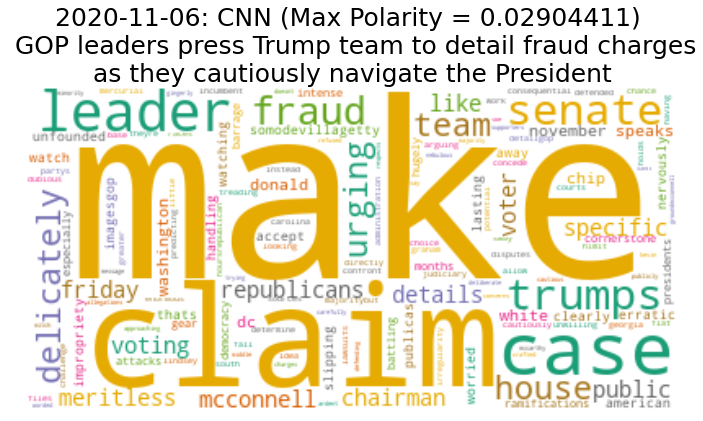

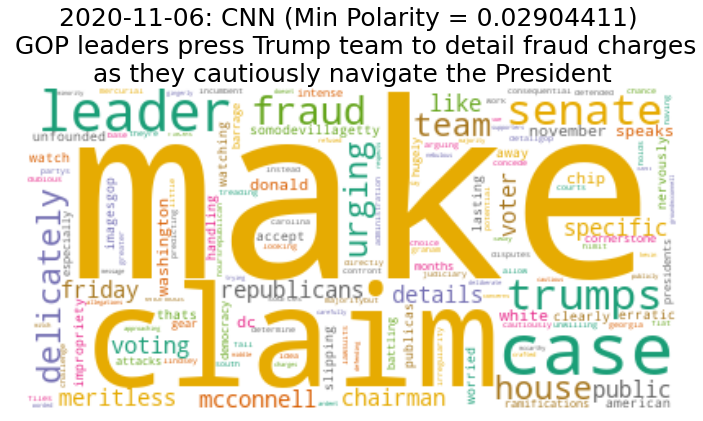

In [11]:
#dlist = datelist
dlist=['2020-12-03']
klist = keylist
# fmode: 0 = max polarity, 1 = max subjectivity, 2 = min polarity, 3 = min subjectivity, 4 = max pol and subj, 5 = min pol and subj
fmode = 0
nitem = findItem(fsave_items, dlist, klist, fmode)
ntitle1 = nitem['date']+': '+nitem['key'].upper()+' (Max Polarity = '+nitem['polarity'][:10]+') \n'
ntitle2 = nitem['title']
plotWordCloud(cleanPunctNum(nitem['text']).strip(), ntitle1 , ntitle2 , stop_words)

fmode = 2
nitem = findItem(fsave_items, dlist, klist, fmode)
ntitle1 = nitem['date']+': '+nitem['key'].upper()+' (Min Polarity = '+nitem['polarity'][:10]+') \n'
ntitle2 = nitem['title']
plotWordCloud(cleanPunctNum(nitem['text']).strip(), ntitle1 , ntitle2 , stop_words)


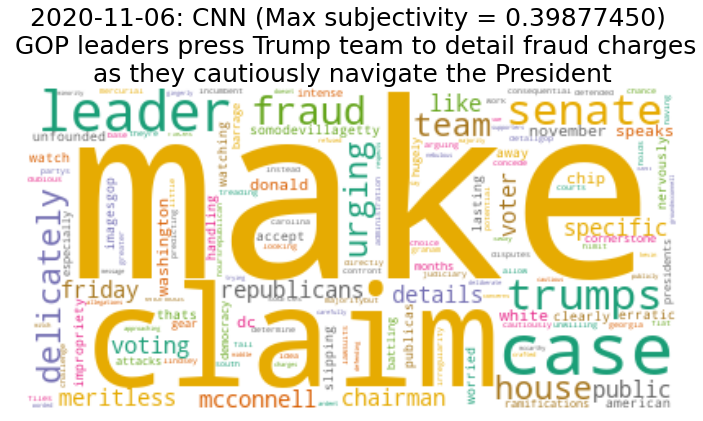

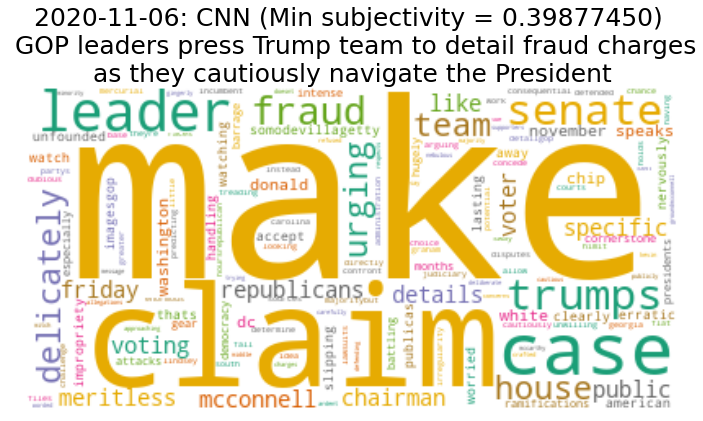

In [12]:
#dlist = datelist
dlist=['2020-12-03']
klist = keylist
# fmode: 0 = max polarity, 1 = max subjectivity, 2 = min polarity, 3 = min subjectivity, 4 = max pol and subj, 5 = min pol and subj
fmode = 1
nitem = findItem(fsave_items, dlist, klist, fmode)
ntitle1 = nitem['date']+': '+nitem['key'].upper()+' (Max subjectivity = '+nitem['subjectivity'][:10]+') \n'
ntitle2 = nitem['title']
plotWordCloud(cleanPunctNum(nitem['text']).strip(), ntitle1 , ntitle2, stop_words )

fmode = 3
nitem = findItem(fsave_items, dlist, klist, fmode)
ntitle1 = nitem['date']+': '+nitem['key'].upper()+' (Min subjectivity = '+nitem['subjectivity'][:10]+') \n'
ntitle2 = nitem['title']
plotWordCloud(cleanPunctNum(nitem['text']).strip(), ntitle1 , ntitle2, stop_words )


In [ ]:
searchNews(save_items, 'washpost')

In [16]:
displayNews(fsave_items, 0)

----cnbc----
----cnn----
----cnn----
----cnn----
----cnn----
----washtimes----
----washtimes----
----washtimes----
----washtimes----
----bbc----
----nyt----
----npr----
----npr----
----npr----
----washpost----
----washpost----
----nbcnews----
----nbcnews----
----wsj----
----wsj----
----cbsnews----
----cbsnews----


In [17]:
cnews_df

,key,date,title,link,sterm,description,text,polarity,subjectivity
0,cnbc,2020-12-03,Cramer urges Biden to heed lessons of Trump's China trade war: 'Taking a hard line gets results',https://www.cnbc.com/2020/12/02/cramers-china-trade-advice-to-biden-taking-a-hard-line-gets-results.html,biden,"""I hope the incoming Biden administration can look at Trump's trade war objectively, because in many ways, really, it worked,"" the ""Mad Money"" hos...",cnbcs jim cramer on wednesday made a plea for joe biden to stay tough on china once the democrat moves into the white house in the new yeari hope ...,0.073861,0.380642
1,cnn,2020-12-03,Jake Tapper to interview Joe Biden and Kamala Harris today,http://rss.cnn.com/~r/rss/cnn_topstories/~3/QJoLAIht_eQ/index.html,biden,CNN's Jake Tapper will interview President-elect Joe Biden and Vice President-elect Kamala Harris on Thursday in their first joint interview since...,washington cnn cnns jake tapper will interview presidentelect joe biden and vice presidentelect kamala harris on thursday in their first joint int...,0.193885,0.345292
2,cnn,2020-12-03,Here are the key priorities of Biden's first 100 days in office,http://rss.cnn.com/~r/rss/cnn_topstories/~3/BgK7S5ssXjw/h_30f9905f47731c2180a3277598663d09,biden,"<div class=""feedflare"">\n<a href=""http://rss.cnn.com/~ff/rss/cnn_topstories?a=BgK7S5ssXjw:U2vIKUWM8o0:yIl2AUoC8zA""><img src=""http://feeds.feedburn...",presidentelect joe biden delivers a thanksgiving address at the queen theatre on november in wilmington delaware mark makelagetty imagespresiden...,0.109610,0.452154
3,cnn,2020-12-03,Opinion: Five steps Democrats can take to win big in Georgia,http://rss.cnn.com/~r/rss/cnn_topstories/~3/EIqFTB4UmP4/index.html,biden,"If the next five weeks were to have a theme song, at least in political circles, it would be ""Georgia On My Mind,"" a song made popular by Ray Char...",arick wierson is a sixtime emmy awardwinning television producer and former senior media adviser to new york mayor michael bloomberg he advises co...,0.143412,0.450691
4,cnn,2020-12-03,Here are the historic firsts in Biden's administration,http://rss.cnn.com/~r/rss/cnn_topstories/~3/swylSRkYuTM/index.html,biden,Several of President-elect Joe Biden's nominees would make history if confirmed by the United States Senate to serve in top roles in his incoming ...,washington cnn several of presidentelect joe biden s nominees would make history if confirmed by the united states senate to serve in top roles in...,0.104609,0.246207
5,washtimes,2020-12-03,The Latest: Kamala Harris names Tina Flournoy chief of staff,https://www.washingtontimes.com/news/2020/dec/3/the-latest-kamala-harris-names-tina-flournoy-chief/?utm_source=RSS_Feed&utm_medium=RSS,biden,<p>WASHINGTON (AP) - The Latest on President-elect Joe Biden (all times local):</p> <p>8:35 a.m.</p> <p>Vice President-elect Kamala Harris is hiri...,washington ap the latest on presidentelect joe biden all times local amvice presidentelect kamala harris is hiring veteran democratic strategist ...,0.084481,0.286777
6,washtimes,2020-12-03,"Psaki, next White House press secretary, a veteran messenger",https://www.washingtontimes.com/news/2020/dec/3/psaki-next-white-house-press-secretary-a-veteran-m/?utm_source=RSS_Feed&utm_medium=RSS,biden,<p>WASHINGTON (AP) - After four years of President Donald Trump serving as his own chief spokesperson and frequently peddling false information an...,washington ap after four years of president donald trump serving as his own chief spokesperson and frequently peddling false information and cons...,0.130074,0.411810
7,washtimes,2020-12-03,Russia waits -- warily -- for Joe Biden to chart course on relations,https://www.washingtontimes.com/news/2020/dec/2/russia-waits-warily-joe-biden-chart-course-relatio/?utm_source=RSS_Feed&utm_medium=RSS,biden,<p>There may be more head-scratching in the Kremlin than anywhere else in the world right now as Russian leaders try to get used to the idea of a ...,there may b

In [ ]:
klist = keylist
plotDayScatInd(fsave_items, '2020-11-03', klist)

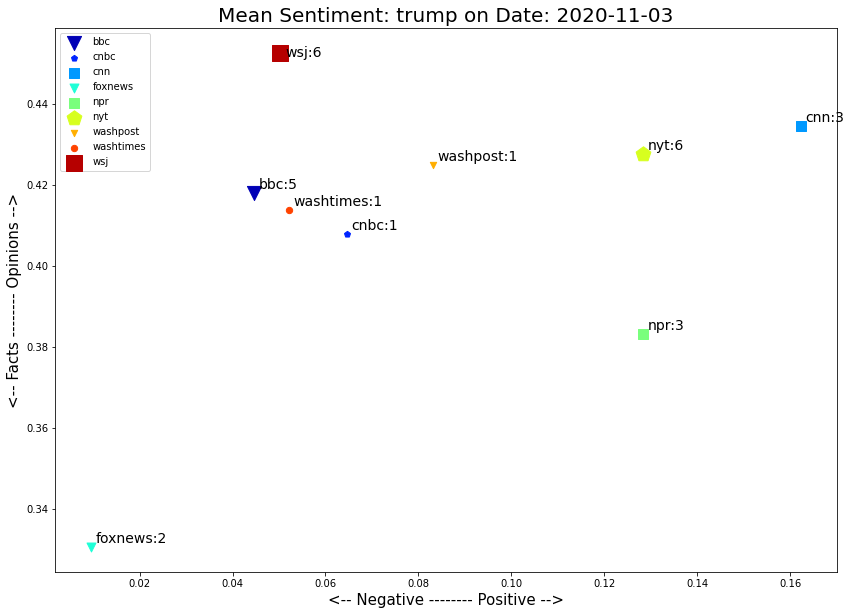

In [14]:
klist = keylist
#klist = ['cnn', 'foxnews', 'nbcnews', 'cbsnews', 'cnbc']
plotDayScatAvg(save_items, '2020-11-03', klist)

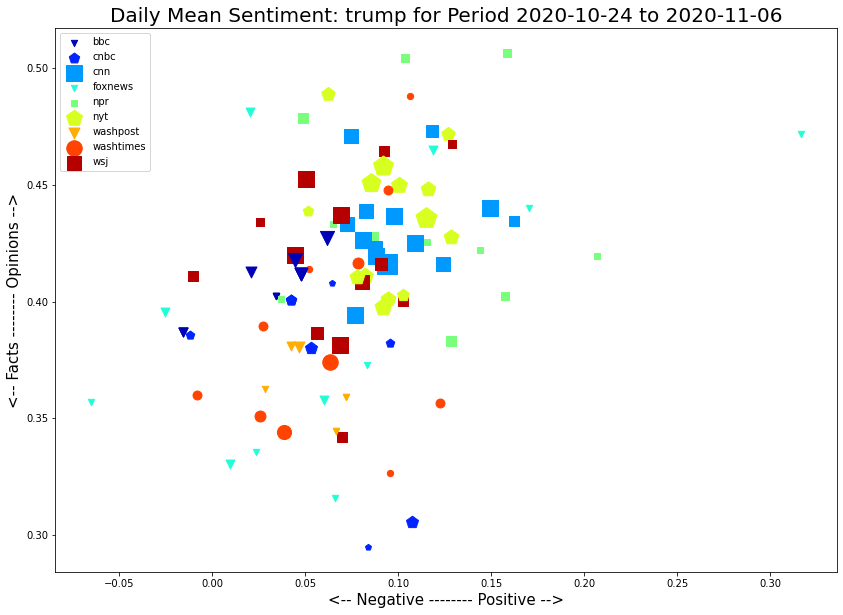

In [15]:
dlist = datelist
klist = keylist
#klist = ['foxnews', 'cnn']
plotMultiDayScatAvg(fsave_items, dlist, klist)

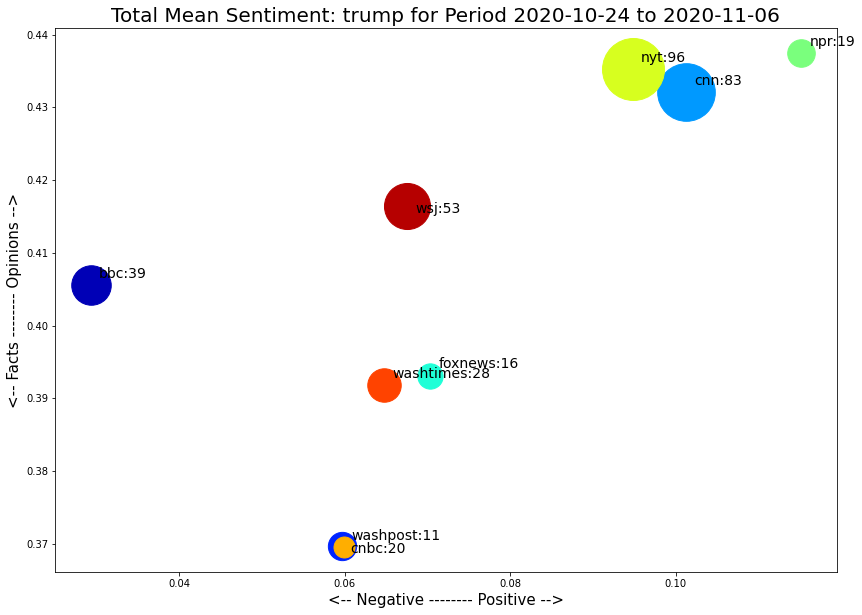

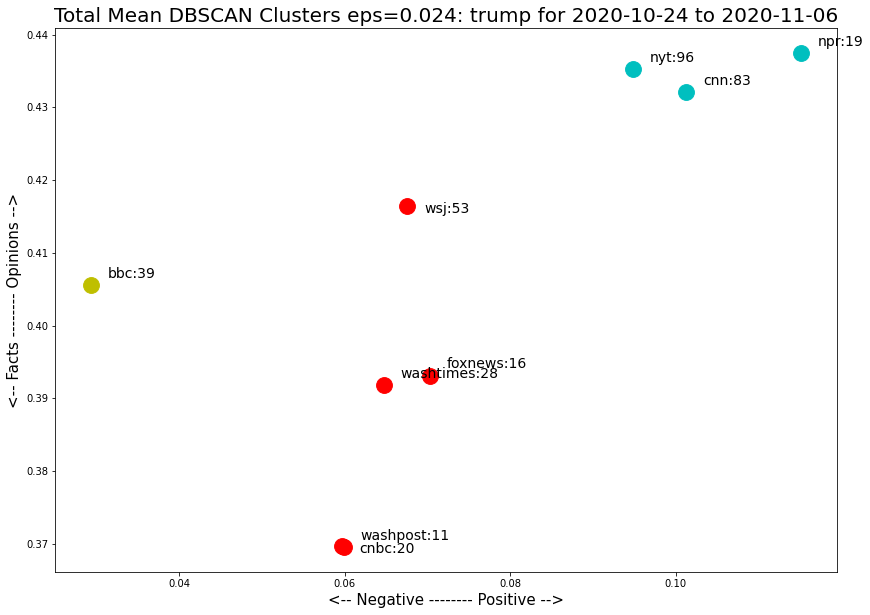

In [16]:
#dlist = ['2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28']
dlist = datelist
klist = keylist
test_avgs = avgSentMultiDay(fsave_items, dlist, klist)
plotTotalScatAvg(test_avgs, dlist, klist)
eps = 0.024
plotTotalScatAvgClusters(test_avgs, dlist, klist, eps)

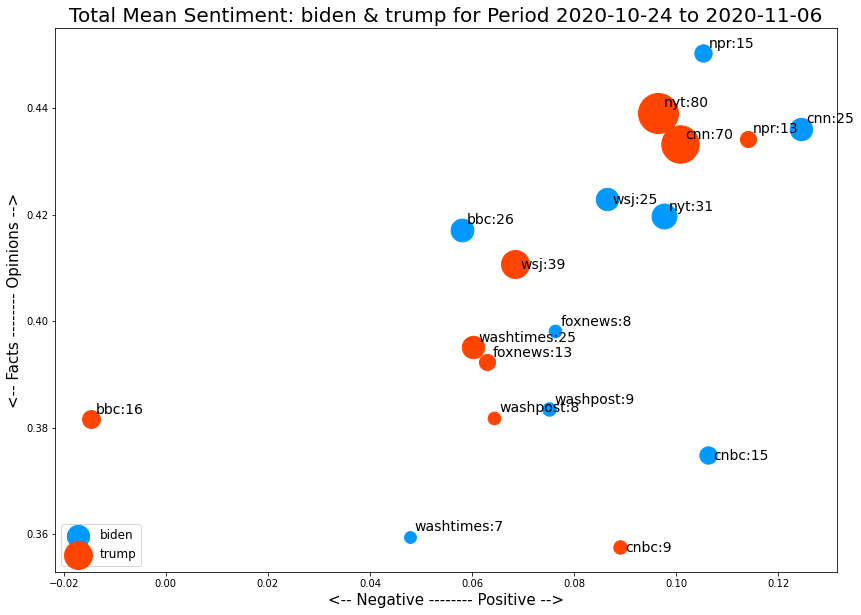

[['bbc', 0.4171637526374276], ['cnbc', 0.37485192988291244], ['cnn', 0.43610572189850744], ['foxnews', 0.39815510054347003], ['npr', 0.4503383439708479], ['nyt', 0.41969169267234296], ['washpost', 0.3834343834189902], ['washtimes', 0.3595042043177738], ['wsj', 0.42291898360667896]]


In [27]:
fname1 = 'newsavg/newsavg_biden_2020-10-24-to-2020-11-06.p'
fname2 = 'newsavg/newsavg_trump_2020-10-24-to-2020-11-06.p'
#dlist = ['2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28']
dlist = datelist
klist = keylist
#klist=['cnn', 'washpost', 'nyt', 'npr']

t=plotTotalScatAvg2(fname1, fname2, dlist, klist)
print(t)

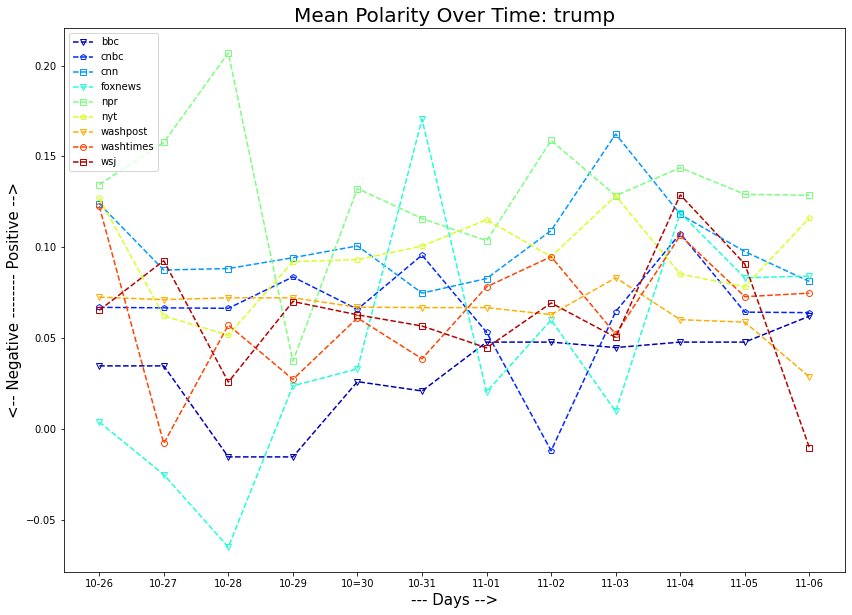

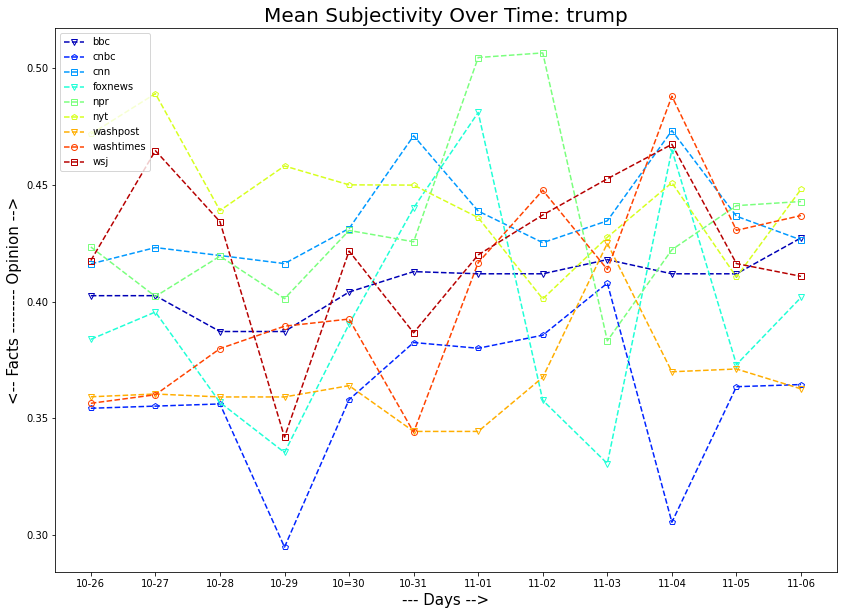

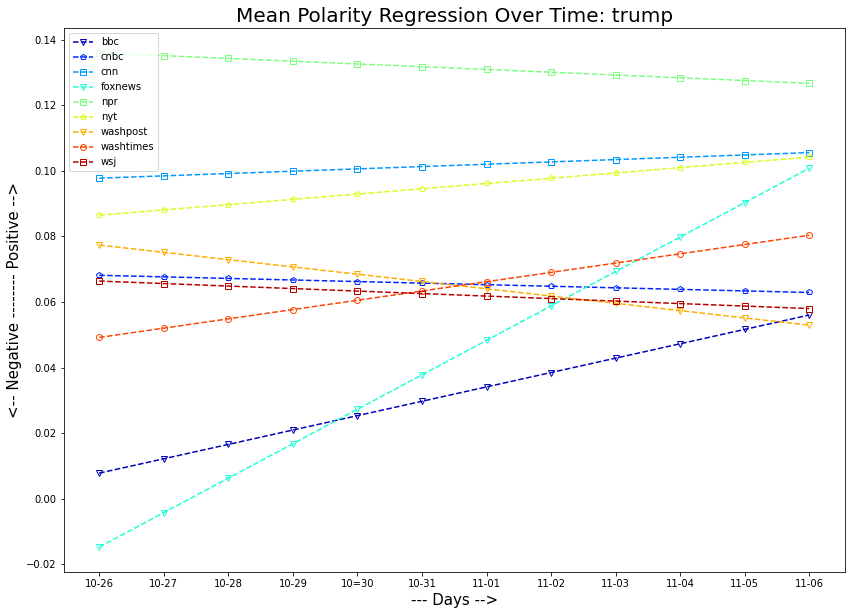

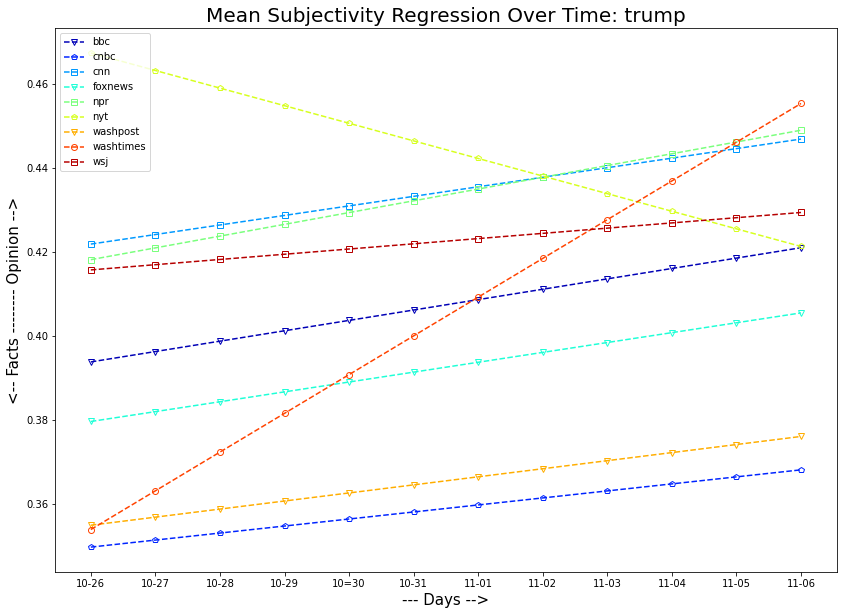

In [17]:
# pmode:  0 = raw polarity, 1 = raw subjectivity, 2 = pol regression, 3 = subjnews/news_trump_2020-10-24-to-2020-11-06.p regression, 4 = pol reg+scat, subj reg+scat
klist = keylist
#klist = ['foxnews', 'wsj']
#klist = ['cnn', 'foxnews']
#klist = ['washpost', 'washtimes']
#dlist = datelist
dlist = [  '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10=30', '2020-10-31', \
          '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06']
plotMultiDay(fsave_items, dlist, klist, 0)
plotMultiDay(fsave_items, dlist, klist, 1)
plotMultiDay(fsave_items, dlist, klist, 2)
plotMultiDay(fsave_items, dlist, klist, 3)
#plotMultiDay(save_items, dlist, klist, 4)
#plotMultiDay(save_items, dlist, klist, 5)

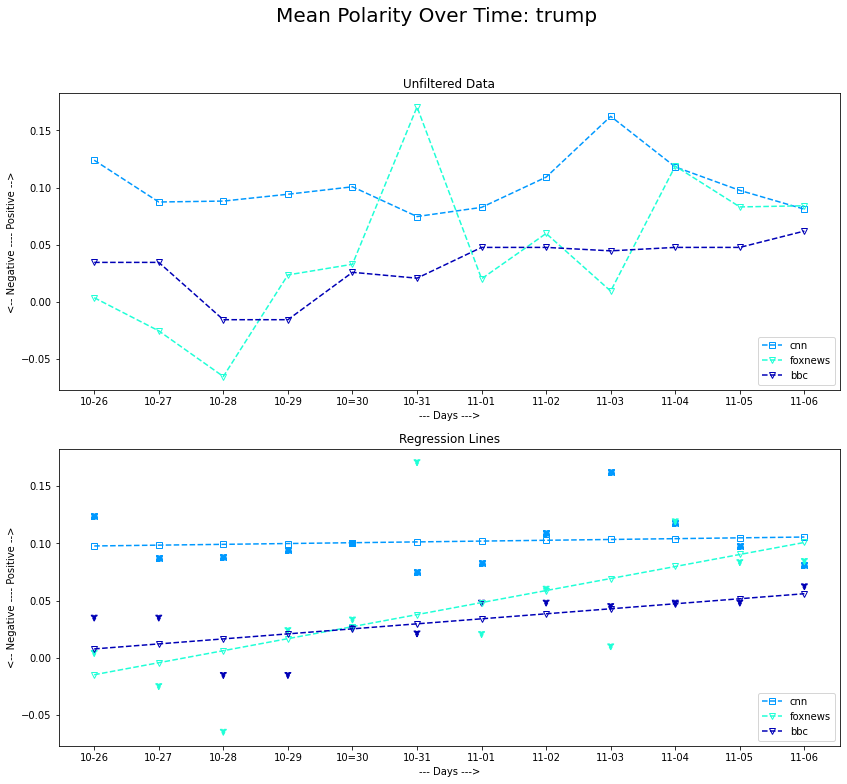

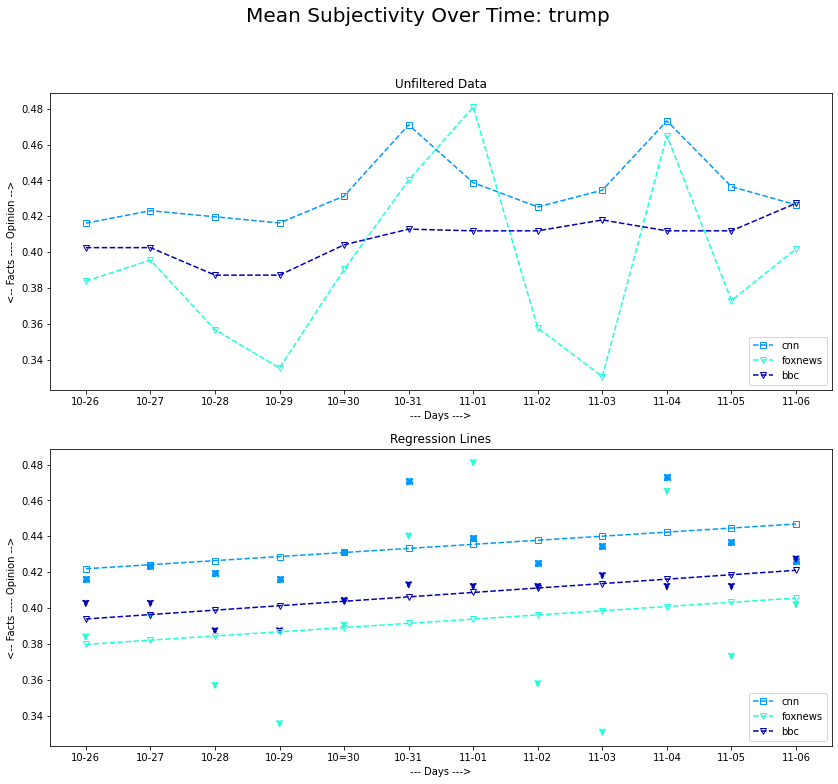

In [4]:
# pmode:  0 = polarity, 1 = subjectivity
klist = keylist
#klist = ['foxnews', 'wsj']
#klist = ['cnbc', 'foxnews', 'nyt']
klist = ['cnn', 'foxnews', 'bbc']
#klist = ['washpost', 'washtimes']
#dlist = datelist
dlist = [  '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10=30', '2020-10-31', \
          '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06']
plotDualMultiDay(fsave_items, dlist, klist, 0)
plotDualMultiDay(fsave_items, dlist, klist, 1)


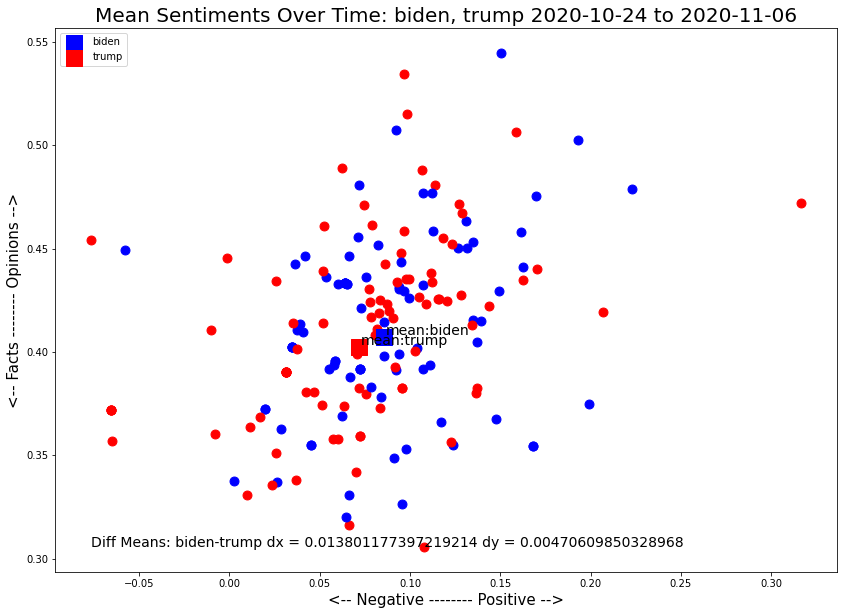

In [31]:
dlist = datelist
#dlist =['2020-11-02']
fname1 = 'newsavg/newsavg_biden_2020-10-24-to-2020-11-06.p'
fname2 = 'newsavg/newsavg_trump_2020-10-24-to-2020-11-06.p'
klist = ['bbc','cnbc', 'foxnews', 'washpost', 'wsj']   # dx = pos biden
klist = ['cnn', 'washpost', 'foxnews'] #dy = pos biden
#klist = ['washtimes']
#klist = ['cnn', 'foxnews']
klist = keylist
plotSentDiffScat(fname1, fname2, dlist, klist)

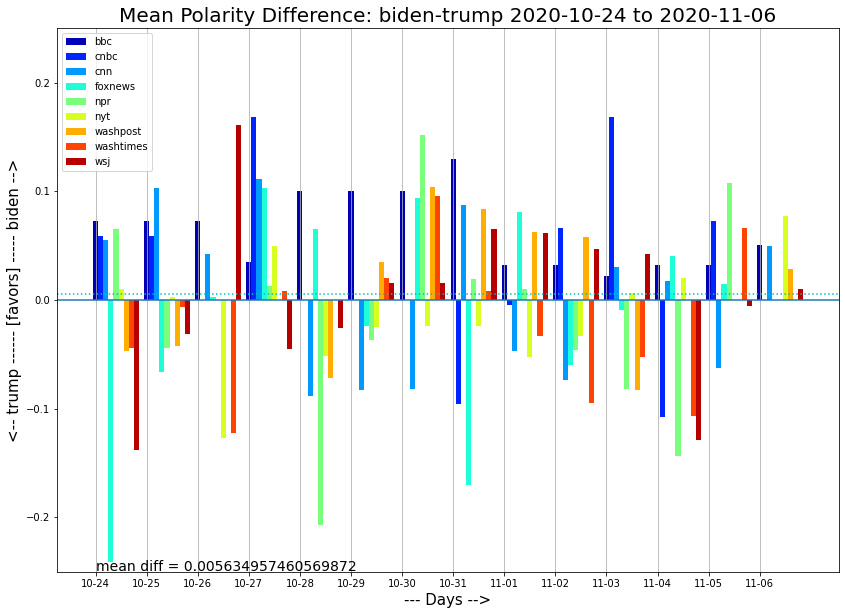

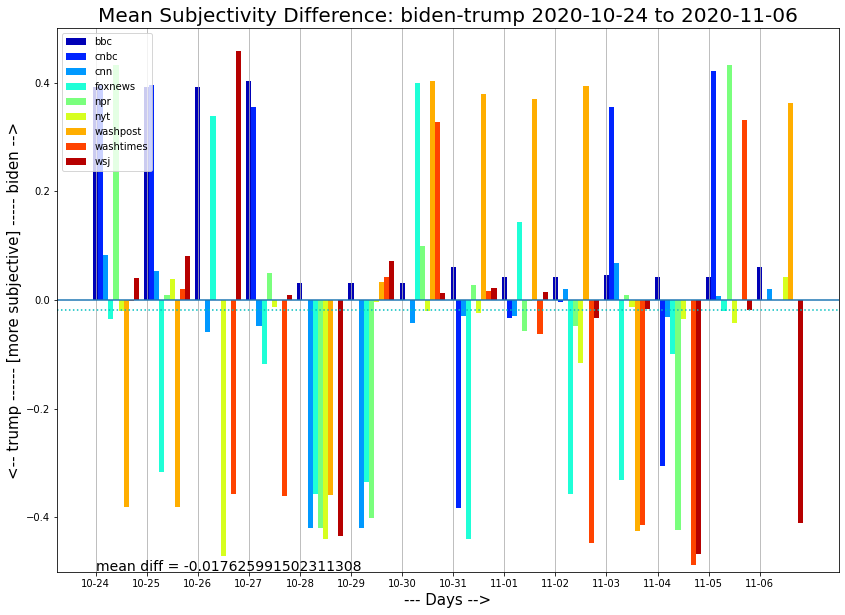

In [32]:
dlist = datelist
#dlist =['2020-11-02']
fname1 = 'newsavg/newsavg_biden_2020-10-24-to-2020-11-06.p'
fname2 = 'newsavg/newsavg_trump_2020-10-24-to-2020-11-06.p'
#klist = ['foxnews', 'washtimes', 'wsj']
#klist = ['cnn', 'washpost', 'npr', 'nbcnews']
klist = keylist
plotSentDiffBar(fname1, fname2, dlist, klist, 0 )
plotSentDiffBar(fname1, fname2, dlist, klist, 1 )


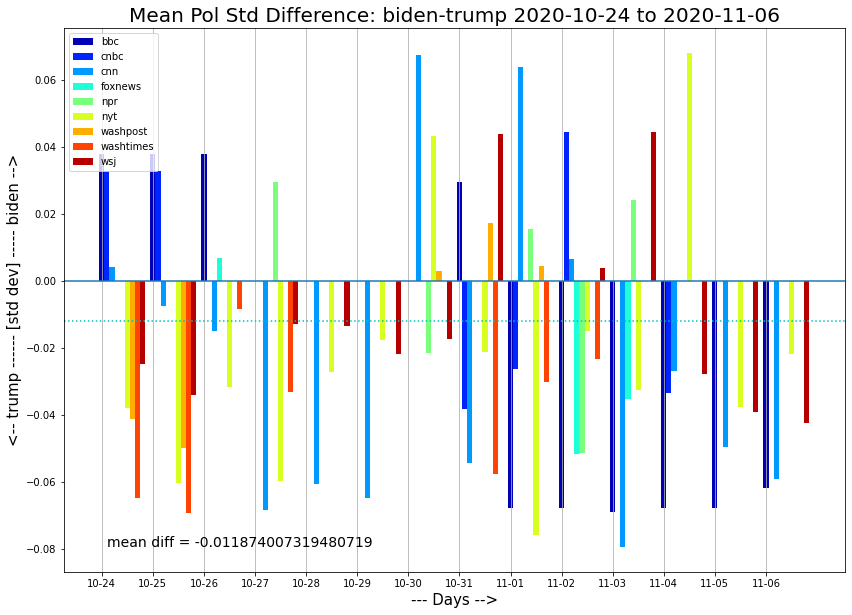

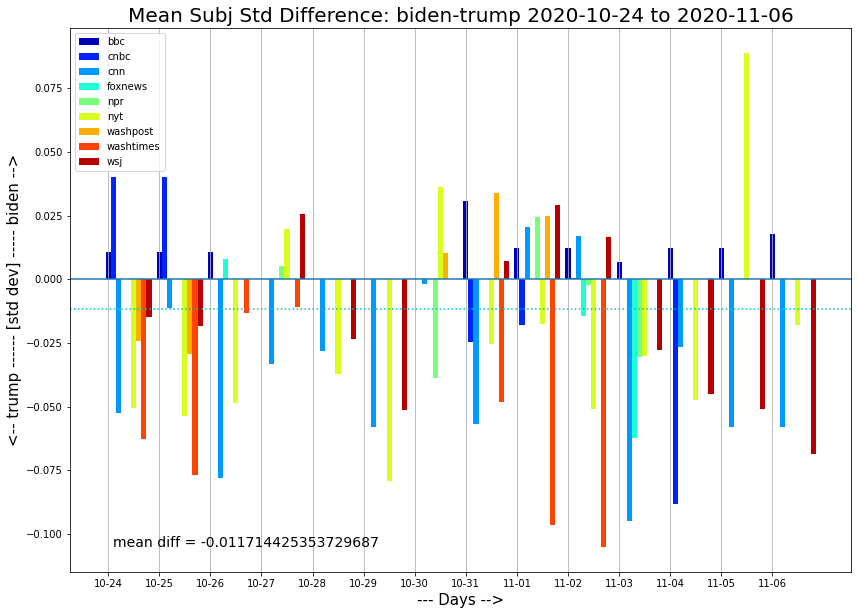

In [33]:
dlist = datelist
#dlist =['2020-10-30','2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03']
fname1 = 'newsavg/newsavg_biden_2020-10-24-to-2020-11-06.p'
fname2 = 'newsavg/newsavg_trump_2020-10-24-to-2020-11-06.p'
#klist = ['washpost', 'cbsnews', 'nyt']
#klist = ['foxnews', 'washtimes', 'wsj']
#klist = ['washpost', 'washtimes']
klist = keylist
pmode = 2 
plotNewsStats(fname1, fname2, dlist, klist, pmode)
pmode = 3
plotNewsStats(fname1, fname2, dlist, klist, pmode)

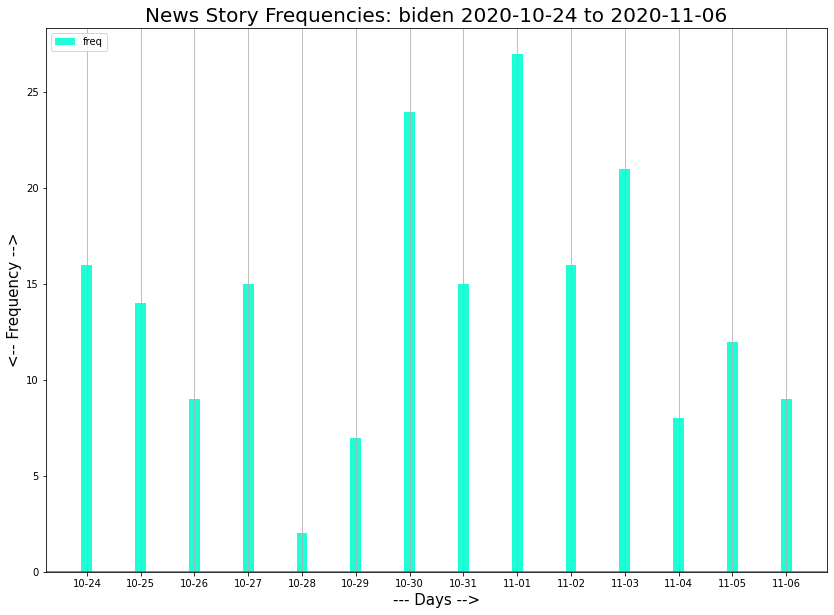

In [34]:
dlist = datelist
plotNewsFreq(fsave_items, dlist)